# Homework 3. Bayesian Tomatoes

<span style="color:red">Rotten Tomatoes does not provide free API keys anymore. I am adjusting the original homework to use TMDB API instead. </span>

In this assignment, you'll be analyzing movie reviews from TMDB (www.themoviedb.org). This assignment will cover:

 * Working with web APIs
 * Making and interpreting predictions from a Bayesian perspective
 * Using the Naive Bayes algorithm to predict whether a movie review is positive or negative
 * Using cross validation to optimize models

Useful libraries for this assignment

* [numpy](http://docs.scipy.org/doc/numpy-dev/user/index.html), for arrays
* [scikit-learn](http://scikit-learn.org/stable/), for machine learning
* [json](http://docs.python.org/2/library/json.html) for parsing JSON data from the web.
* [pandas](http://pandas.pydata.org/), for data frames
* [matplotlib](http://matplotlib.org/), for plotting
* [requests](http://docs.python-requests.org/en/latest/), for downloading web content

In [1]:
%matplotlib inline

import json

import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import sys

pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 30)

# set some nicer defaults for matplotlib
from matplotlib import rcParams

#these colors come from colorbrewer2.org. Each is an RGB triplet
dark2_colors = [(0.10588235294117647, 0.6196078431372549, 0.4666666666666667),
                (0.8509803921568627, 0.37254901960784315, 0.00784313725490196),
                (0.4588235294117647, 0.4392156862745098, 0.7019607843137254),
                (0.9058823529411765, 0.1607843137254902, 0.5411764705882353),
                (0.4, 0.6509803921568628, 0.11764705882352941),
                (0.9019607843137255, 0.6705882352941176, 0.00784313725490196),
                (0.6509803921568628, 0.4627450980392157, 0.11372549019607843),
                (0.4, 0.4, 0.4)]

rcParams['figure.figsize'] = (10, 6)
rcParams['figure.dpi'] = 150
rcParams['axes.color_cycle'] = dark2_colors
rcParams['lines.linewidth'] = 2
rcParams['axes.grid'] = False
rcParams['axes.facecolor'] = 'white'
rcParams['font.size'] = 14
rcParams['patch.edgecolor'] = 'none'


def remove_border(axes=None, top=False, right=False, left=True, bottom=True):
    """
    Minimize chartjunk by stripping out unnecessary plot borders and axis ticks
    
    The top/right/left/bottom keywords toggle whether the corresponding plot border is drawn
    """
    ax = axes or plt.gca()
    ax.spines['top'].set_visible(top)
    ax.spines['right'].set_visible(right)
    ax.spines['left'].set_visible(left)
    ax.spines['bottom'].set_visible(bottom)
    
    #turn off all ticks
    ax.yaxis.set_ticks_position('none')
    ax.xaxis.set_ticks_position('none')
    
    #now re-enable visibles
    if top:
        ax.xaxis.tick_top()
    if bottom:
        ax.xaxis.tick_bottom()
    if left:
        ax.yaxis.tick_left()
    if right:
        ax.yaxis.tick_right()

/Users/pear/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


## Introduction

This basic task of categorizing text has many applications. All of the following questions boil down to text classification:

 * Is a movie review positive or negative?
 * Is an email spam, or not?
 * Is a comment on a blog discussion board appropriate, or not?
 * Is a tweet about your company positive, or not?
 

Language is incredibly nuanced, and there is an entire field of computer science dedicated to the topic (Natural Language Processing). Nevertheless, we can construct basic language models using fairly straightforward techniques. 

## The Data

You will be starting with a database of Movies, derived from the MovieLens dataset. This dataset includes information for about 10,000 movies, including the IMDB id for each movie. 

Your first task is to download TMDB reviews from 3000 of these movies, using the API (Application Programming Interface).

### Working with Web APIs
Web APIs are a more convenient way for programs to interact with websites. TMDB has a nice API that gives access to its data in JSON format.

To use this, you will first need to create an account and register for an API key.

After you have a key, the documentation page (https://developers.themoviedb.org/3/getting-started) shows the various data you can fetch. The basic pattern for fetching this data with Python is as follows:

In [2]:
base_url = "https://api.themoviedb.org/3/"

In [3]:
# General movie info

api_key = "fa1c1ad70969d2a07cb831bfc0e1f819"
movie_id = "346364"
url = "https://api.themoviedb.org/3/movie/%s" %movie_id

payload = {"api_key":api_key}
data = requests.request("GET", url, data=payload).text
data = json.loads(data) # load a json string into a collection of lists and dicts

print json.dumps(data['title'], indent=2)  # dump an object into a json string

"It"


In [4]:
# Reviews

url = "https://api.themoviedb.org/3/movie/%s/reviews" %movie_id

payload = {"api_key":api_key, "page":1}
data = requests.request("GET", url, data=payload).text
data = json.loads(data)

print json.dumps(data['results'][0], indent=2)

{
  "content": "\"Skarsg\u00e5rd goes to hell and back to craft a truly malevolent creation, utterly believable as the black soul of King\u2019s cursed small town...\"\r\n\r\nRead the full review here: http://screen-space.squarespace.com/reviews/2017/9/6/it.html", 
  "url": "https://www.themoviedb.org/review/59afaa2cc3a3682e6401064f", 
  "id": "59afaa2cc3a3682e6401064f", 
  "author": "Screen-Space"
}


## Part 1: Get the data
Here's a chunk of the MovieLens Dataset:

In [2]:
from io import StringIO  
movie_txt = requests.get('https://raw.github.com/cs109/cs109_data/master/movies.dat').text
movie_file = StringIO(movie_txt) # treat a string like a file
movies = pd.read_csv(movie_file, delimiter='\t')

# print the first row
movies[['id', 'title', 'imdbID', 'year']].iloc[0]

id                1
title     Toy story
imdbID       114709
year           1995
Name: 0, dtype: object

In [21]:
movies.head()

,id,title,imdbID,spanishTitle,imdbPictureURL,year,rtID,rtAllCriticsRating,rtAllCriticsNumReviews,rtAllCriticsNumFresh,rtAllCriticsNumRotten,rtAllCriticsScore,rtTopCriticsRating,rtTopCriticsNumReviews,rtTopCriticsNumFresh,rtTopCriticsNumRotten,rtTopCriticsScore,rtAudienceRating,rtAudienceNumRatings,rtAudienceScore,rtPictureURL
0,1,Toy story,114709,Toy story (juguetes),http://ia.media-imdb.com/images/M/MV5BMTMwNDU0...,1995,toy_story,9,73,73,0,100,8.5,17,17,0,100,3.7,102338,81,http://content7.flixster.com/movie/10/93/63/10...
1,2,Jumanji,113497,Jumanji,http://ia.media-imdb.com/images/M/MV5BMzM5NjE1...,1995,1068044-jumanji,5.6,28,13,15,46,5.8,5,2,3,40,3.2,44587,61,http://content8.flixster.com/movie/56/79/73/56...
2,3,Grumpy Old Men,107050,Dos viejos gruñones,http://ia.media-imdb.com/images/M/MV5BMTI5MTgy...,1993,grumpy_old_men,5.9,36,24,12,66,7,6,5,1,83,3.2,10489,66,http://content6.flixster.com/movie/25/60/25602...
3,4,Waiting to Exhale,114885,Esperando un respiro,http://ia.media-imdb.com/images/M/MV5BMTczMTMy...,1995,waiting_to_exhale,5.6,25,14,11,56,5.5,11,5,6,45,3.3,5666,79,http://content9.flixster.com/movie/10/94/17/10...
4,5,Father of the Bride Part II,113041,Vuelve el padre de la novia (Ahora también abu...,http://ia.media-imdb.com/images/M/MV5BMTg1NDc2...,1995,father_of_the_bride_part_ii,5.3,19,9,10,47,5.4,5,1,4,20,3,13761,64,http://content8.flixster.com/movie/25/54/25542...


In [22]:
movies.shape

(9423, 21)

#### P1.1

We'd like you to write a function that looks up the first page of the TMDB reviews for a movie in the `movies` dataframe. This involves two steps:

1. Use the `Find` API (/find/{external_id}) to look up the TMDB movie id from the IMDB id
1. Use the `Reviews` API to fetch the first page reviews for this movie

Not all movies have TMDB IDs. In these cases, your function should return `None`. The detailed spec is below. We are giving you some freedom with how you implement this, but you'll probably want to break this task up into several small functions.

**Hint**
In some situations, the leading 0s in front of IMDB ids are important. IMDB ids have 7 digits and starts with string 'tt'.

In [5]:
"""
Function
--------
fetch_reviews(movies, row)

Use the TMDB web API to fetch reviews for a particular movie

Parameters
----------
movies : DataFrame 
  The movies data above
row : int
  The row of the movies DataFrame to use
  
Returns
-------
If you can match the IMDB id to a TMDB ID:
  A DataFrame, containing the first page reviews 
  for the movie. 
  This should have the following columns:
    critic : Name of the critic
    fresh  : 'fresh' or 'rotten'
    imdb   : IMDB id for the movie
    publication: Publication that the critic writes for
    quote  : string containing the movie review quote
    review_data: Date of review
    rtid   : Rotten Tomatoes ID for the movie
    title  : Name of the movie
    
If you cannot match the IMDB id to a TMDB ID, return None

Examples
--------
>>> reviews = fetch_reviews(movies, 0)
>>> print len(reviews)
20
>>> print reviews.irow(1)
critic                                               Derek Adams
fresh                                                      fresh
imdb                                                      114709
publication                                             Time Out
quote          So ingenious in concept, design and execution ...
review_date                                           2009-10-04
rtid                                                        9559
title                                                  Toy story
Name: 1, dtype: object
"""
#your code here

def get_tmdb_id(imdb_id):
    
    # check if the imdb_id is in the correct format
    imdb_id = 'tt'+'0'*(7-len(str(imdb_id)))+str(imdb_id)
    
    # find TMDB movie ID
    url = "https://api.themoviedb.org/3/find/%s" %imdb_id
    payload = {"api_key":api_key, "external_source":"imdb_id"}
    data_text = requests.request("GET", url, data=payload).text
    data = json.loads(data_text)
    
    try:
        tmdb_id = data['movie_results'][0]['id']
    except:
        tmdb_id = None
    
    return tmdb_id
        

def fetch_reviews(movies, row):
    
    # get the IMDB ID
    imdb_id = movies['imdbID'].iloc[row]
    title = movies['title'].iloc[row]
    
    # get the tmdb_id
    tmdb_id = get_tmdb_id(imdb_id)
    
    if tmdb_id:
        # get the first page reviews
        url = "https://api.themoviedb.org/3/movie/%s/reviews" %tmdb_id
        payload = {'api_key':api_key, 'page':1}
        data = requests.request("GET", url, data=payload).text
        data = json.loads(data)
        reviews = pd.DataFrame(data['results'])
        if not reviews.empty:
            reviews['imdb_id'] = imdb_id 
            reviews['tmdb_id'] = tmdb_id
            reviews['title'] = title
        else:
            reviews = None
    else:
        reviews = None
    
    return reviews


In [30]:
get_tmdb_id(114709)

862

In [6]:
imdb_id = 'tt0000439'

url = "https://api.themoviedb.org/3/find/%s" %imdb_id
payload = {"api_key":api_key, "external_source":"imdb_id"}
data_text = requests.request("GET", url, data=payload).text
data = json.loads(data_text)

In [23]:
data['movie_results'][0]['id']

5698

In [7]:
movie_id = '346364'
url = "https://api.themoviedb.org/3/movie/%s/reviews" %movie_id

payload = {'api_key':api_key, 'page':1}
data = requests.request("GET", url, data=payload).text
data = json.loads(data)

In [8]:
data

{u'id': 346364,
 u'page': 1,
 u'results': [{u'author': u'Screen-Space',
   u'content': u'"Skarsg\xe5rd goes to hell and back to craft a truly malevolent creation, utterly believable as the black soul of King\u2019s cursed small town..."\r\n\r\nRead the full review here: http://screen-space.squarespace.com/reviews/2017/9/6/it.html',
   u'id': u'59afaa2cc3a3682e6401064f',
   u'url': u'https://www.themoviedb.org/review/59afaa2cc3a3682e6401064f'},
  {u'author': u'Nay Myo Myat Ko',
   u'content': u"**This movie went right to the trash.** I cannot believe what Warner Bros has done for this piece of trash.\r\nYes, there have been rave reviews for this movie, but we recommend that you do not mind them, as we should not be teaching children on how to safely get sodomized by a monster.\r\n\r\nThese directors' brains are also in the trash. Now let's put the MPAA R rating right into the trash where it is supposed to go. Final warning: **Don't let your kids watch trash.**",
   u'id': u'59bfb66c9251

In [9]:
reviews = pd.DataFrame(data['results'])

In [12]:
reviews

,author,content,id,url,imdb_id
0,Screen-Space,"""Skarsgård goes to hell and back to craft a tr...",59afaa2cc3a3682e6401064f,https://www.themoviedb.org/review/59afaa2cc3a3...,tt0000439
1,Nay Myo Myat Ko,**This movie went right to the trash.** I cann...,59bfb66c9251414745014240,https://www.themoviedb.org/review/59bfb66c9251...,tt0000439
2,Gimly,More _Fucked-Up-Coming-of-Age_ than _Monster-M...,59c098eac3a36804db00aeb6,https://www.themoviedb.org/review/59c098eac3a3...,tt0000439
3,Rythwik,If you are gonna watch this movie go to the th...,59c711d19251415b5404ecef,https://www.themoviedb.org/review/59c711d19251...,tt0000439


#### P1.2

Use the function you wrote to retrieve reviews for the first 3,000 movies in the movies dataframe.

##### Hints
* Be careful about the request limit! (40 requests every 10 seconds). Test your code on smaller inputs before scaling. You are responsible if you hit the limit the day the assignment is due :)
* This will take a while to download. If you don't want to re-run this function every time you restart the notebook, you can save and re-load this data as a CSV file. However, please don't submit this file

In [6]:
"""
Function
--------
build_table

Parameters
----------
movies : DataFrame
  The movies data above
rows : int
  The number of rows to extract reviews for
  
Returns
--------
A dataframe
  The data obtained by repeatedly calling `fetch_reviews` on the first `rows`
  of `movies`, discarding the `None`s,
  and concatenating the results into a single DataFrame
"""
#your code here

def build_table(movies, rows):
    reviews = pd.DataFrame(columns=['imdb_id','tmdb_id','title','author','content','id','url'])
    
    for i in xrange(rows):
        review = fetch_reviews(movies,i)
        time.sleep(0.5)
        if not (review is None):
            reviews = pd.concat([reviews,review],axis=0)
            
        # print progress
        print i,'\r',
        sys.stdout.flush()
            
    return reviews.reset_index(drop=True)
        

In [72]:
#checking 

critics = build_table(movies,20)

In [73]:
critics

,author,content,id,imdb_id,title,tmdb_id,url
0,John Chard,Do me a favour. Put your lip over your head......,5424aec90e0a263b74004629,107050,Grumpy Old Men,11520,https://www.themoviedb.org/review/5424aec90e0a...
1,John Chard,"You don't live with me, you live among the rem...",5510d7769251415c960007f3,113277,Heat,949,https://www.themoviedb.org/review/5510d7769251...
2,Gimly,Partly I'm disappointed in myself for taking s...,59337e49c3a3685a24014d42,113277,Heat,949,https://www.themoviedb.org/review/59337e49c3a3...
3,talisencrw,"Most probably my least favourite film, both of...",57ec2169c3a3687e1f000111,112896,Dracula: Dead and Loving It,12110,https://www.themoviedb.org/review/57ec2169c3a3...
4,talisencrw,Not as bad as it's notoriously condemned as be...,573f961ac3a36808ac0003a7,112760,Cutthroat Island,1408,https://www.themoviedb.org/review/573f961ac3a3...


In [3]:
#you can toggle which lines are commented, if you
#want to re-load your results to avoid repeatedly calling this function

#critics = build_table(movies, 3000)
#critics.to_csv('critics.csv', index=False, encoding='utf-8')
critics = pd.read_csv('data_hw3/critics_rt.csv')

In [21]:
critics.head()

,critic,date,fresh,imdb,original_score,publication,quote,review_date,rt_id,title
0,Derek Adams,2009-10-04,fresh,114709,5/5,Time Out,"So ingenious in concept, design and execution ...",http://www.timeout.com/film/reviews/87745/toy-...,9559,Toy Story
1,Richard Corliss,2008-08-31,fresh,114709,NaN,TIME Magazine,The year's most inventive comedy.,"http://www.time.com/time/magazine/article/0,91...",9559,Toy Story
2,David Ansen,2008-08-18,fresh,114709,NaN,Newsweek,A winning animated feature that has something ...,http://www.newsweek.com/id/104199,9559,Toy Story
3,Leonard Klady,2008-06-09,fresh,114709,NaN,Variety,The film sports a provocative and appealing st...,http://www.variety.com/review/VE1117941294.htm...,9559,Toy Story
4,Jonathan Rosenbaum,2008-03-10,fresh,114709,NaN,Chicago Reader,"An entertaining computer-generated, hyperreali...",http://onfilm.chicagoreader.com/movies/capsule...,9559,Toy Story


## Part 2: Explore

<span style="color:red">We are switching to archived reviews data from RT since TMDB does not have enought reviews. </span>

Before delving into analysis, get a sense of what these data look like. Answer the following questions. Include your code!

**2.1** How many reviews, critics, and movies are in this dataset?


In [22]:
print 'Number of reviews :', len(critics)
print 'Number of critics :', critics['critic'].nunique()
print 'Number of movies :', critics['imdb'].nunique()

Number of reviews : 15610
Number of critics : 621
Number of movies : 1931


**2.2** What does the distribution of number of reviews per reviewer look like? Make a histogram

(0, 100)

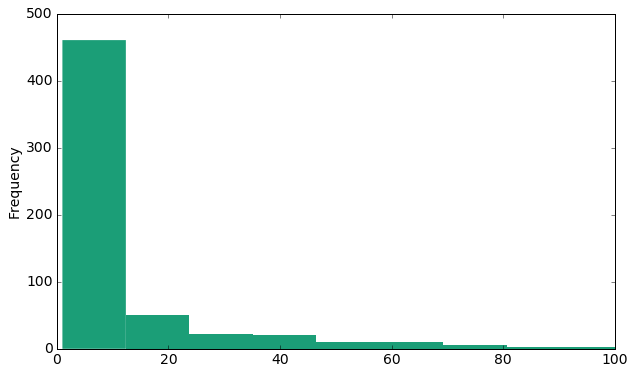

In [26]:
ax = critics['critic'].value_counts().plot.hist(bins=100)
ax.set_xlim(0,100)

**2.3** List the 5 critics with the most reviews, along with the publication they write for

In [40]:
for ind, count in critics.groupby(by='critic').size().sort_values(ascending=False).head(5).iteritems():
    print ind, count
    print ' publications :', critics.groupby(by='critic').get_group(ind)['publication'].unique()

 Roger Ebert 1138
 publications : ['Chicago Sun-Times' 'At the Movies']
James Berardinelli 806
 publications : ['ReelViews']
Janet Maslin 519
 publications : ['New York Times']
Variety Staff 434
 publications : ['Variety']
Jonathan Rosenbaum 414
 publications : ['Chicago Reader']


**2.4** Of the critics with > 100 reviews, plot the distribution of average "freshness" rating per critic

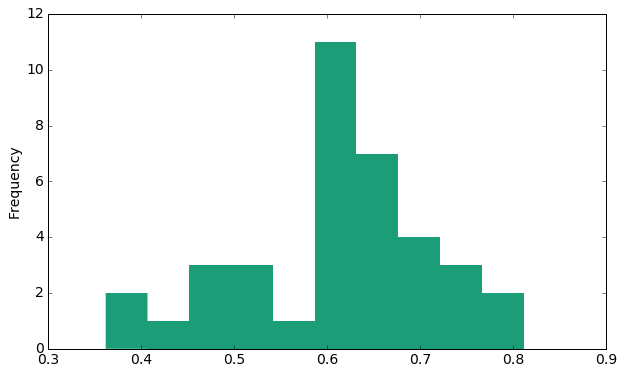

In [44]:
critic_100 = [critic for critic,count in critics['critic'].value_counts().iteritems() if count > 100]
critics_100 = critics[critics['critic'].isin(critic_100)]
critics_100 = pd.get_dummies(critics_100,columns=['fresh'])
critics_100.groupby(by='critic')['fresh_fresh'].mean().plot.hist()

**2.5**
Using the original `movies` dataframe, plot the rotten tomatoes Top Critics Rating as a function of year. Overplot the average for each year, ignoring the score=0 examples (some of these are missing data). Comment on the result -- is there a trend? What do you think it means?

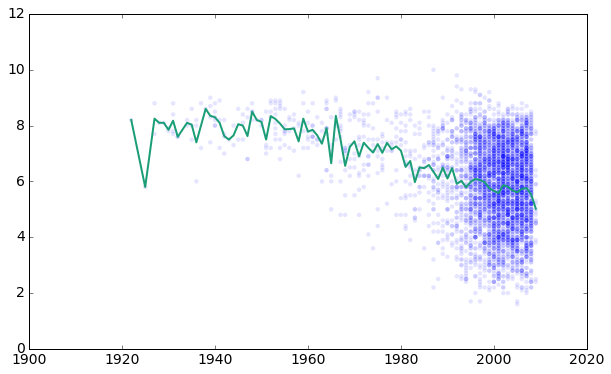

In [28]:
movies['rtTopCriticsRating'] = pd.to_numeric(movies['rtTopCriticsRating'],errors='coerce')

mean_ratings = movies[movies['rtTopCriticsRating']>0].groupby(by='year').mean()['rtTopCriticsRating']

x = movies['year'].values
y = movies['rtTopCriticsRating'].values
ind = np.where((y!=0)&(np.isfinite(y)))
x = x[ind]
y = y[ind]

fig, ax = plt.subplots(1)
ax.scatter(x,y,alpha=0.1)
ax.plot(mean_ratings.index, mean_ratings.values)

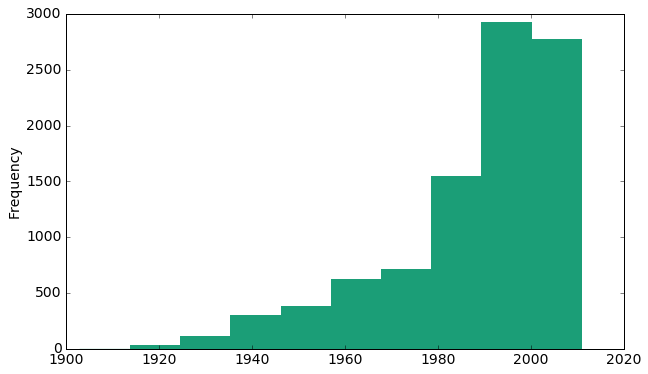

In [52]:
movies['year'].plot.hist()

<span style="color:green">There is a trend of the average ratings decreasing over the years. One obvious observation from the plot is that the number of movies increases for later years. There are very few movies before 1980 in the data. This would introduce a selection bias into the data. Older movies get higher ratings. It is likely that the more popular or more critically acclaimed older movies are more likely to make it into the dataset while almost all of the new releases are in the dataset.</span>

## Part 3: Sentiment Analysis

You will now use a [Naive Bayes classifier](https://en.wikipedia.org/wiki/Naive_Bayes_classifier) to build a prediction model for whether a review is fresh or rotten, depending on the text of the review. See Lecture 9 for a discussion of Naive Bayes.

Most models work with numerical data, so we need to convert the textual collection of reviews to something numerical. A common strategy for text classification is to represent each review as a "bag of words" vector -- a long vector
of numbers encoding how many times a particular word appears in a blurb.

Scikit-learn has an object called a `CountVectorizer` that turns text into a bag of words. Here's a quick tutorial:

In [4]:
from sklearn.feature_extraction.text import CountVectorizer

text = ['Hop on pop', 'Hop off pop', 'Hop Hop hop']
print "Original text is\n", '\n'.join(text)

vectorizer = CountVectorizer(min_df=0)

# call `fit` to build the vocabulary
vectorizer.fit(text)

# call `transform` to convert text to a bag of words
x = vectorizer.transform(text)

# CountVectorizer uses a sparse array to save memory, but it's easier in this assignment to 
# convert back to a "normal" numpy array
x = x.toarray()

print
print "Transformed text vector is \n", x

# `get_feature_names` tracks which word is associated with each column of the transformed x
print
print "Words for each feature:"
print vectorizer.get_feature_names()

# Notice that the bag of words treatment doesn't preserve information about the *order* of words, 
# just their frequency

Original text is
Hop on pop
Hop off pop
Hop Hop hop

Transformed text vector is 
[[1 0 1 1]
 [1 1 0 1]
 [3 0 0 0]]

Words for each feature:
[u'hop', u'off', u'on', u'pop']


**3.1**

Using the `critics` dataframe, compute a pair of numerical X, Y arrays where:
    
 * X is a `(nreview, nwords)` array. Each row corresponds to a bag-of-words representation for a single review. This will be the *input* to your model.
 * Y is a `nreview`-element 1/0 array, encoding whether a review is Fresh (1) or Rotten (0). This is the desired *output* from your model.


In [13]:
critics.head()

,critic,date,fresh,imdb,original_score,publication,quote,review_date,rt_id,title
0,Derek Adams,2009-10-04,fresh,114709,5/5,Time Out,"So ingenious in concept, design and execution ...",http://www.timeout.com/film/reviews/87745/toy-...,9559,Toy Story
1,Richard Corliss,2008-08-31,fresh,114709,NaN,TIME Magazine,The year's most inventive comedy.,"http://www.time.com/time/magazine/article/0,91...",9559,Toy Story
2,David Ansen,2008-08-18,fresh,114709,NaN,Newsweek,A winning animated feature that has something ...,http://www.newsweek.com/id/104199,9559,Toy Story
3,Leonard Klady,2008-06-09,fresh,114709,NaN,Variety,The film sports a provocative and appealing st...,http://www.variety.com/review/VE1117941294.htm...,9559,Toy Story
4,Jonathan Rosenbaum,2008-03-10,fresh,114709,NaN,Chicago Reader,"An entertaining computer-generated, hyperreali...",http://onfilm.chicagoreader.com/movies/capsule...,9559,Toy Story


In [5]:
#hint: Consult the scikit-learn documentation to
#      learn about what these classes do do
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB

"""
Function
--------
make_xy

Build a bag-of-words training set for the review data

Parameters
-----------
critics : Pandas DataFrame
    The review data from above
    
vectorizer : CountVectorizer object (optional)
    A CountVectorizer object to use. If None,
    then create and fit a new CountVectorizer.
    Otherwise, re-fit the provided CountVectorizer
    using the critics data
    
Returns
-------
X : numpy array (dims: nreview, nwords)
    Bag-of-words representation for each review.
Y : numpy array (dims: nreview)
    1/0 array. 1 = fresh review, 0 = rotten review

Examples
--------
X, Y = make_xy(critics)
"""
def make_xy(critics, vectorizer=None):
    #Your code here 
    
    text = critics['quote'] 
    if not vectorizer:
        vectorizer = CountVectorizer()
        
    vectorizer.fit(text)
    X = vectorizer.transform(text)
    X = X.toarray()
    Y = pd.get_dummies(critics,columns=['fresh'])['fresh_fresh'].values

    return X,Y


In [6]:
X, Y = make_xy(critics)

In [27]:
X.shape, Y.shape

((15610, 22464), (15610,))


**3.2** Next, randomly split the data into two groups: a
training set and a validation set. 

Use the training set to train a `MultinomialNB` classifier,
and print the accuracy of this model on the validation set

**Hint**
You can use [`train_test_split`](http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.train_test_split.html) to split up the training data

In [7]:
# your code here
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)
clf = MultinomialNB()
clf.fit(X_train, Y_train)
clf.score(X_train, Y_train)

0.92048366431774509

In [34]:
Y_train.sum()/Y_train.size

0.6069827033952595

**3.3:**

We say a model is **overfit** if it performs better on the training data than on the test data. Is this model overfit? If so, how much more accurate is the model on the training data compared to the test data?

In [36]:
# Your code here. Print the accuracy on the test and training dataset
print 'Accuracy on training set : ', clf.score(X_train, Y_train)
print 'Accuracy on test set : ', clf.score(X_test, Y_test)

 Accuracy on training set :  0.921124279308
Accuracy on test set :  0.773542600897


*Interpret these numbers in a few sentences here* 

<span style="color:green">The model is overfitting. The training set accuracy is quite a lot higher than the testing set (>0.1). The accuracy on the testing set is still better than the benchmark of predicting one class. Some model tuning should improve the test set accuracy. </span>

**3.4: Model Calibration**

Bayesian models like the Naive Bayes classifier have the nice property that they compute probabilities of a particular classification -- the `predict_proba` and `predict_log_proba` methods of `MultinomialNB` compute these probabilities. 

Being the respectable Bayesian that you are, you should always assess whether these probabilities are **calibrated** -- that is, whether a prediction made with a confidence of `x%` is correct approximately `x%` of the time. We care about calibration because it tells us whether we can trust the probabilities computed by a model. If we can trust model probabilities, we can make better decisions using them (for example, we can calculate how much we should bet or invest in a given prediction).

Let's make a plot to assess model calibration. Schematically, we want something like this:

<img src="http://i.imgur.com/ea5B6zr.png" width=500px>

In words, we want to:

* Take a collection of examples, and compute the freshness probability for each using `clf.predict_proba`
* Gather examples into bins of similar freshness probability (the diagram shows 5 groups -- you should use something closer to 20)
* For each bin, count the number of examples in that bin, and compute the fraction of examples in the bin which are fresh
* In the upper plot, graph the expected P(Fresh) (x axis) and observed freshness fraction (Y axis). Estimate the uncertainty in observed freshness fraction $F$ via the [equation](http://en.wikipedia.org/wiki/Binomial_proportion_confidence_interval) $\sigma = \sqrt{F (1-F) / N}$
* Overplot the line y=x. This is the trend we would expect if the model is calibrated
* In the lower plot, show the number of examples in each bin

**Hints**

The output of `clf.predict_proba(X)` is a `(N example, 2)` array. The first column gives the probability $P(Y=0)$ or  $P(Rotten)$, and the second gives $P(Y=1)$ or $P(Fresh)$.

The above image is just a guideline -- feel free to explore other options!

In [38]:
"""
Function
--------
calibration_plot

Builds a plot like the one above, from a classifier and review data

Inputs
-------
clf : Classifier object
    A MultinomialNB classifier
X : (Nexample, Nfeature) array
    The bag-of-words data
Y : (Nexample) integer array
    1 if a review is Fresh
"""    
#your code here

def calibration_plot(clf, X, Y):
    
    prob = clf.predict_proba(X)
    prob_fresh = zip(*prob)[1]
    bins = 20
    counts, bin_edges = np.histogram(prob_fresh, bins=bins) # get the histogram output
    fractions = np.full(bins, np.nan) # initialize an array
    errors = np.full(bins, np.nan) # standard deviation of the estimated proportional parameter
    
    # calculate a freshness fraction for each bin
    for i in xrange(bins):
        ind = np.where((bin_edges[i] <= prob_fresh)&(prob_fresh < bin_edges[i+1]))
        fraction = Y[ind].mean()
        fractions[i] = fraction
        errors[i] = np.sqrt(fraction*(1-fraction)/len(Y[ind]))
        
    # plots
    fig, axes = plt.subplots(2,1)
    
    x1 = [(bin_edges[i]+bin_edges[i+1])/2. for i in xrange(bins)]
    axes[0].errorbar(x1, fractions, yerr=errors)
    axes[0].plot(x1, x1, '--b')
    
    axes[1].bar(bin_edges[:-1], counts, width=0.04, align='edge')


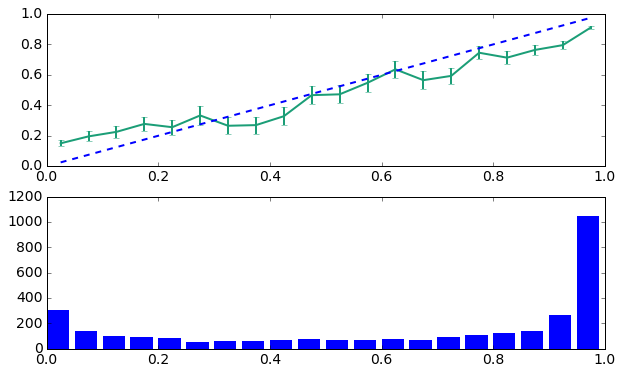

In [72]:
calibration_plot(clf, X_test, Y_test)

**3.5** We might say a model is *over-confident* if the freshness fraction is usually closer to 0.5 than expected (that is, there is more uncertainty than the model predicted). Likewise, a model is *under-confident* if the probabilities are usually further away from 0.5. Is this model generally over- or under-confident? 

<span style="color:green">It's pretty close. The model is slightly over-confident.</span>

#### Cross Validation

Our classifier has a few free parameters. The two most important are:

 1. The `min_df` keyword in `CountVectorizer`, which will ignore words which appear in fewer than `min_df` fraction of reviews. Words that appear only once or twice can lead to overfitting, since words which occur only a few times might correlate very well with Fresh/Rotten reviews by chance in the training dataset.
 
 2. The [`alpha` keyword](http://scikit-learn.org/stable/modules/naive_bayes.html#multinomial-naive-bayes) in the Bayesian classifier is a "smoothing parameter" -- increasing the value decreases the sensitivity to any single feature, and tends to pull prediction probabilities closer to 50%. 

As discussed in lecture and HW2, a common technique for choosing appropriate values for these parameters is **cross-validation**. Let's choose good parameters by maximizing the cross-validated log-likelihood.

**3.6** Using `clf.predict_log_proba`, write a function that computes the log-likelihood of a dataset

In [27]:
"""
Function
--------
log_likelihood

Compute the log likelihood of a dataset according to a bayesian classifier. 
The Log Likelihood is defined by

L = Sum_fresh(logP(fresh)) + Sum_rotten(logP(rotten))

Where Sum_fresh indicates a sum over all fresh reviews, 
and Sum_rotten indicates a sum over rotten reviews
    
Parameters
----------
clf : Bayesian classifier
x : (nexample, nfeature) array
    The input data
y : (nexample) integer array
    Whether each review is Fresh
    
Returns
-------
L : a float value of the log likelihood

"""
#your code here

def log_likelihood(clf, X, Y):
    
    log_proba_rotten, log_proba_fresh  = zip(*clf.predict_log_proba(X))
    
    Sum_fresh = np.asarray(log_proba_fresh)[np.where(Y==1)].sum()
    Sum_rotten = np.asarray(log_proba_rotten)[np.where(Y==0)].sum()
    
    return Sum_fresh+Sum_rotten


In [28]:
log_likelihood(clf, X_test, Y_test)

-1768.6218130560856

Here's a function to estimate the cross-validated value of a scoring function, given a classifier and data

In [29]:
from sklearn.model_selection import cross_val_score

def cv_score(clf, X, Y, score_func):
    """
    Uses 5-fold cross validation to estimate a score of a classifier
    
    Inputs
    ------
    clf : Classifier object
    x : Input feature vector
    y : Input class labels
    score_func : Function like log_likelihood, that takes (clf, x, y) as input,
                 and returns a score
                 
    Returns
    -------
    The average score obtained by randomly splitting (x, y) into training and 
    test sets, fitting on the training set, and evaluating score_func on the test set
    
    Examples
    cv_score(clf, x, y, log_likelihood)
    """
    
    scores = cross_val_score(clf, X, Y, scoring=score_func)
    
    return scores.mean()

# as a side note, this function is builtin to the newest version of sklearn. We could just write
# sklearn.cross_validation.cross_val_score(clf, x, y, scorer=log_likelihood).

**3.7**

Fill in the remaining code in this block, to loop over many values of `alpha` and `min_df` to determine
which settings are "best" in the sense of maximizing the cross-validated log-likelihood

In [30]:
# but we need to separate a test set before doing CV?

critics_train, critics_test = train_test_split(critics, test_size=0.2)

In [31]:
#the grid of parameters to search over
alphas = [0, .1, 1, 5, 10, 50]
min_dfs = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]

#Find the best value for alpha and min_df, and the best classifier
best_alpha = None
best_min_df = None
max_loglike = -np.inf

for alpha in alphas:
    for min_df in min_dfs:         
        vectorizer = CountVectorizer(min_df = min_df)       
        X, Y = make_xy(critics_train, vectorizer)
        
        #your code here
        clf = MultinomialNB(alpha=alpha)
        score = cv_score(clf, X, Y, log_likelihood)
        print score
        if score > max_loglike:
            best_alpha = alpha
            best_min_df = min_df
            max_loglike = score
        

nan
nan
nan
-2621.41193532
-2740.01343977
-3686.29448804
-3673.35775435
-2554.46341258
-2621.18891445
-2740.01296437
-2491.55686496
-2424.65455613
-2385.810559
-2619.29614504
-2740.00890689
-4004.45125131
-2910.97387197
-2279.64163618
-2612.94193429
-2739.99558934
-5301.0113997
-4017.84256186
-2345.24422831
-2608.44636019
-2739.98932821
-6467.03424912
-5915.52357001
-3708.42097533
-2637.71124969
-2740.28104699


In [32]:
print "alpha: %f" % best_alpha
print "min_df: %f" % best_min_df

alpha: 5.000000
min_df: 0.001000


In [6]:
best_alpha = 5.0
best_min_df = 0.001

**3.8** Now that you've determined values for alpha and min_df that optimize the cross-validated log-likelihood, repeat the steps in 3.1, 3.2, and 3.4 to train a final classifier with these parameters, re-evaluate the accuracy, and draw a new calibration plot.

In [54]:
# your code here
# There is something wrong here. We are not supposed to use the test set in any of the model building, 
# but we were forced to write a function that performs the count vectorization and returns X and Y without
# returning the object. So I will have to contaminate the test set here unless I want to re-write everything (no). 

vectorizer = CountVectorizer(min_df = best_min_df) 
X, Y = make_xy(critics, vectorizer)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)
clf = MultinomialNB(alpha=best_alpha)
clf.fit(X_train, Y_train)


MultinomialNB(alpha=5.0, class_prior=None, fit_prior=True)

In [36]:
print 'Accuracy on training set : ', clf.score(X_train, Y_train)
print 'Accuracy on test set : ', clf.score(X_test, Y_test)

Accuracy on training set :  0.7866752082
Accuracy on test set :  0.733504163997


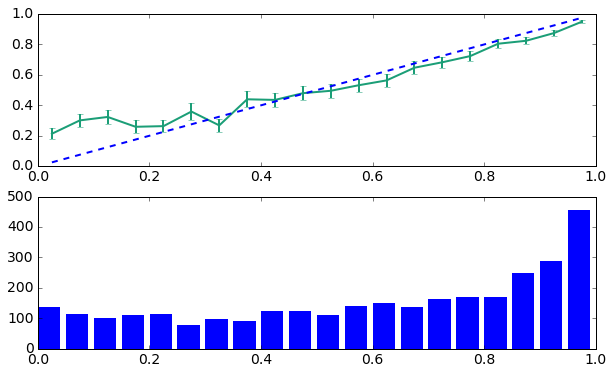

In [39]:
calibration_plot(clf, X_test, Y_test)

**3.9** Discuss the various ways in which Cross-Validation has affected the model. Is the new model more or less accurate? Is overfitting better or worse? Is the model more or less calibrated?

<span style="color:green">The new accuracy on the test set is lower. However, the overfitting is better in this model. The training set accuracy is only slightly higher than the test set. The model is more calibrated.</span>

*To think about/play with, but not to hand in: What would happen if you tried this again using a function besides the log-likelihood -- for example, the classification accuracy?*

## Part 4: Interpretation. What words best predict a fresh or rotten review?

**4.1**
Using your classifier and the `vectorizer.get_feature_names` method, determine which words best predict a positive or negative review. Print the 10 words
that best predict a "fresh" review, and the 10 words that best predict a "rotten" review. For each word, what is the model's probability of freshness if the word appears one time?

#### Hints

* Try computing the classification probability for a feature vector which consists of all 0s, except for a single 1. What does this probability refer to?

* `np.eye` generates a matrix where the ith row is all 0s, except for the ith column which is 1.

In [35]:
# your code here

feature_names = np.asarray(vectorizer.get_feature_names())
n_features = len(feature_names)

X_features = np.eye(n_features)
prob_features = clf.predict_proba(X_features)
prob_features_rotten, prob_features_fresh = zip(*prob_features) # unzip
ind_fresh = np.argsort(prob_features_fresh)[::-1] # sorted indices for fresh
ind_rotten = np.argsort(prob_features_rotten)[::-1] # sorted indices for rotten

print 'Top 5 features for fresh reviews :\n',feature_names[ind_fresh[:5]]
print 'Top 5 features for rotten reviews :\n', feature_names[ind_rotten[:5]]

Top 5 features for fresh reviews :
[u'delight' u'touching' u'witty' u'kubrick' u'perfect']
Top 5 features for rotten reviews :
[u'lame' u'unfortunately' u'uninspired' u'pointless' u'bland']


**4.2**

One of the best sources for inspiration when trying to improve a model is to look at examples where the model performs poorly. 

Find 5 fresh and rotten reviews where your model performs particularly poorly. Print each review.

In [50]:
print critics.iloc[ind_worst_rotten[474]], prob_fresh[ind_worst_rotten[474]]

critic                                                  Roger Ebert
date                                                     2000-01-01
fresh                                                        rotten
imdb                                                          99939
original_score                                                  2/4
publication                                       Chicago Sun-Times
quote             Walken is one of the few undeniably charismati...
review_date       http://www.rogerebert.com/reviews/king-of-new-...
rt_id                                                      98816619
title                                              King of New York
Name: 8256, dtype: object 0.993045392702


In [48]:
# your code here

prob_rotten, prob_fresh = zip(*clf.predict_proba(X))
ind_worst_fresh = np.argsort(prob_fresh)
ind_worst_rotten = np.argsort(prob_rotten)

count = 0
i = 0
while count<5:
    if critics.iloc[ind_worst_fresh[i],2]=='fresh':
        print 'Worst Fresh %i \n  ' % i,critics.iloc[ind_worst_fresh[i],6]
        count += 1
    i += 1

count = 0
i = 0
while count<5:
    if critics.iloc[ind_worst_rotten[i],2]=='rotten':
        print 'Worst Rotten %i \n  ' % i,critics.iloc[ind_worst_rotten[i],6]
        count += 1
    i += 1

Worst Fresh 6 
   Some of the gags don't work, but fewer than in any previous Brooks film that I've seen, and when the jokes are meant to be bad, they are riotously poor. What more can one ask of Mel Brooks?
Worst Fresh 45 
   Though it's a good half hour too long, this overblown 1993 spin-off of the 60s TV show otherwise adds up to a pretty good suspense thriller.
Worst Fresh 57 
   The gangland plot is flimsy (bad guy Peter Greene wears too much eyeliner), and the jokes are erratic, but it's a far better showcase for Carrey's comic-from-Uranus talent than Ace Ventura.
Worst Fresh 58 
   There's too much talent and too strong a story to mess it up. There was potential for more here, but this incarnation is nothing to be ashamed of, and some of the actors answer the bell.
Worst Fresh 62 
   There's a lot more to Nowhere in Africa -- too much, actually ... Yet even if the movie has at least one act too many, the question that runs through it -- of whether belonging to a place is a matte

**4.3** What do you notice about these mis-predictions? Naive Bayes classifiers assume that every word affects the probability independently of other words. In what way is this a bad assumption? In your answer, report your classifier's Freshness probability for the review "This movie is not remarkable, touching, or superb in any way".

<span style="color:green">Some of the issues the classifier is having is interpreting contradicting statements. This is difficult to solve especially with the Naive Bayes model. Interpreting each word independently loses the ability to capture the tone of the whole sentence. Some sentiments can only be interpreted correctly if we take context into account.</span>  

In [55]:
x = vectorizer.transform(['This movie is not remarkable, touching, or superb in any way'])

In [58]:
x.toarray()

array([[0, 0, 0, ..., 0, 0, 0]])

In [59]:
clf.predict_proba(x)

array([[ 0.00890126,  0.99109874]])

<span style="color:green">The freshness probability of this review is 0.99.</span>

**4.4**
If this was your final project, what are 3 things you would try in order to build a more effective review classifier? What other exploratory or explanatory visualizations do you think might be helpful?

*Your answer here*

<span style="color:green">I would try to implement more feature extractions. Other than using a single word count, I would implement strings of words as a feature at least up to two word strings. I would do more inspections on the features. Visualize the performance of the classifier on the number of features. I would try to reduce the number of features by implementing some types of weighting or excluding common words. 
If time permits, the more ambitious approach is to try to also analyze the sentiments of sentences instead of each word separately. </span>